<a href="https://colab.research.google.com/github/tomomitanaka00/Blog-Price-Prediction/blob/main/Interpretability_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_description.txt    
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
Data loaded successfully. Shape: (1460, 81)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SHAP values for the first instance:
Id: 51.7044
MSSubClass: 204.7348
LotFrontage: 559.9530
LotArea: -753.7286
OverallQual: -21281.0683
OverallCond: 1265.8781
YearBuilt: -393.1909
YearRemodAdd: 1866.9124
MasVnrArea: -344.7533
BsmtFinSF1: 1158.4423
BsmtFinSF2: -74.7854
BsmtUnfSF: 234.5623
TotalBsmtSF: 4042.6147
1stFlrSF: -1040.1343
2ndFlrSF: -736.8862
LowQualFinSF: 2.7385
GrLivArea: -17037.2459
BsmtFullBath: -113.5917
BsmtHalfBath: 27.7124
FullBath: -689.6203
HalfBath: -241.2705
BedroomAbvGr: 177.6237
KitchenAbvGr: 52.8711
TotRmsAbvGrd: -107.1600
Fireplaces: -346.7784
GarageYrBlt: -871.1048
GarageCars: -2115.4334
GarageArea: -3980.9211
WoodDeckSF: 121.0156
OpenPorchSF: -818.8226
EnclosedPorch: 32.9629
3SsnPorch: -8.9573
ScreenPorch: -109.7049
PoolArea: -8.4873
MiscVal: 2.6971
MoSold: -473.7284
YrSold: -114.4822
MSZoning_FV: -10.6825
MSZoning_RH: -1.3113
MSZoning_RL: 165.7335
MSZoning_RM: 90.6277
Street_Pave: -0.2781
Alley_Pave: -3.7712
Alley_missing: 30.8685
LotShape_IR2: -4.1272
LotShap

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


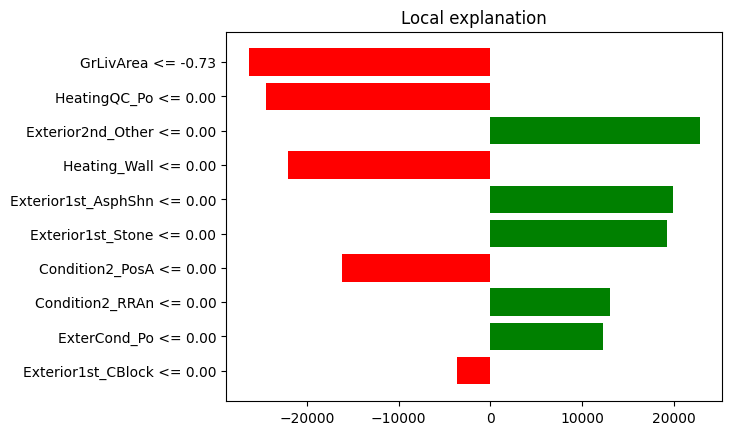

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


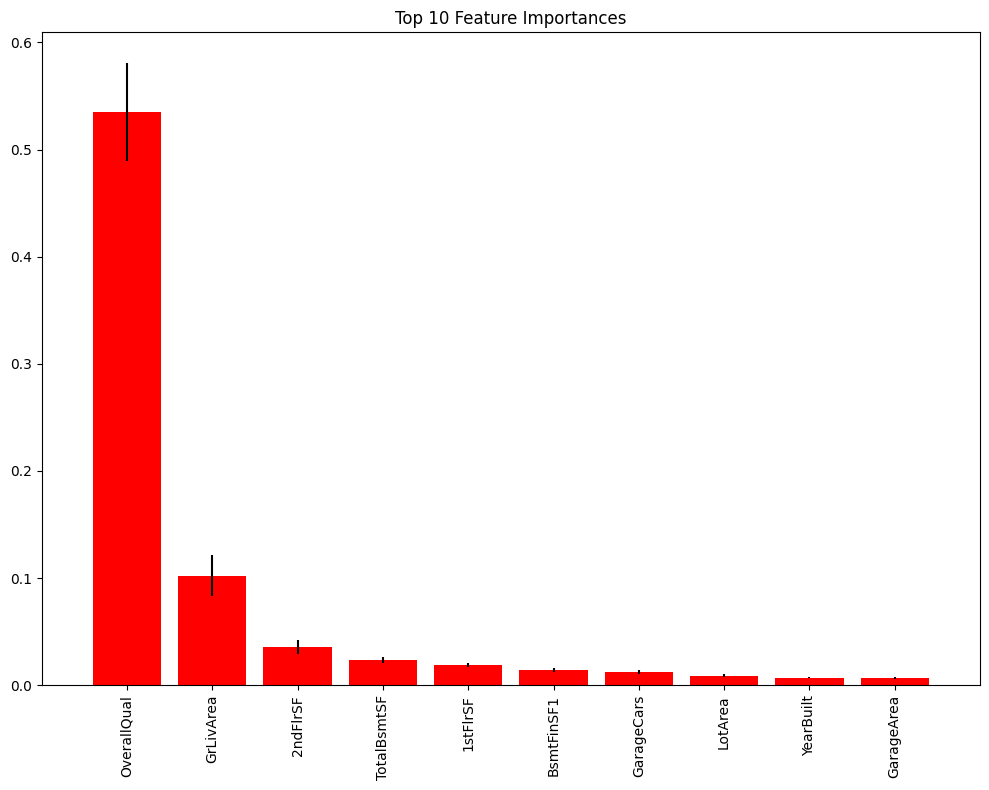

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ValueError: Shape of passed values is (1168, 259), indices imply (1168, 80)

In [10]:
import eli5
from eli5.sklearn import PermutationImportance

# Install necessary libraries
!pip install kaggle shap lime eli5 interpret

# Set up Kaggle API
from google.colab import files
import os

# Upload Kaggle API credentials
print("Please upload your kaggle.json file.")
uploaded = files.upload()

# Move the uploaded file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip house-prices-advanced-regression-techniques.zip

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('train.csv')
print("Data loaded successfully. Shape:", df.shape)

# Separate features and target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get feature names after preprocessing
feature_names = (numeric_features.tolist() +
                 pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())

# SHAP analysis
import shap
import matplotlib.pyplot as plt

# Ensure no missing values in the training and test sets after transformation
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Create a SHAP explainer for the trained model
explainer = shap.TreeExplainer(pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_test_transformed)

# Print SHAP values for the first instance
print("SHAP values for the first instance:")
for feature, value in zip(feature_names, shap_values[0]):
    print(f"{feature}: {value:.4f}")

# Plot and save the SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.savefig('shap_summary_plot.png', bbox_inches='tight', dpi=300)  # Save with tight layout and higher resolution
plt.close()  # Close the plot to prevent it from displaying in the notebook environment

# LIME analysis
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# First, ensure we use the preprocessed data
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Create a LIME explainer using the transformed data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_transformed,  # Use the transformed numeric data
    feature_names=feature_names,
    mode="regression"
)

# Explain a single instance from the transformed data
exp = explainer.explain_instance(
    X_test_transformed[0],  # Use the transformed test data instance
    pipeline.named_steps['model'].predict,  # Directly use the model's predict method
)

# Save LIME explanation plot as an image
fig = exp.as_pyplot_figure()
plt.savefig('lime_explanation.png', bbox_inches='tight')  # Save the figure as a PNG file
plt.show()

import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance

# Transform the test data using the preprocessor
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Now use the transformed data for permutation importance
perm = PermutationImportance(pipeline.named_steps['model'], random_state=42).fit(X_test_transformed, y_test)

# Extract feature importances
importances = perm.feature_importances_
std = perm.feature_importances_std_

# Sort the feature importances in descending order and keep only the top 10
indices = np.argsort(importances)[::-1][:10]
top_features = np.array(feature_names)[indices]
top_importances = importances[indices]
top_std = std[indices]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 8))
plt.title("Top 10 Feature Importances")
plt.bar(range(len(top_importances)), top_importances, color="r", yerr=top_std, align="center")
plt.xticks(range(len(top_importances)), top_features, rotation=90)
plt.xlim([-1, len(top_importances)])
plt.tight_layout()
plt.savefig('eli5_top_10_feature_importance.png')  # Save the figure as a PNG file
plt.show()

from interpret import show
from interpret.blackbox import ShapKernel
from sklearn.impute import SimpleImputer

from interpret.blackbox import ShapKernel
from sklearn.impute import SimpleImputer

# Ensure no missing values in the training and test sets after transformation
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

# Impute any remaining missing values
imputer = SimpleImputer(strategy='mean')
X_train_transformed = imputer.fit_transform(X_train_transformed)
X_test_transformed = imputer.transform(X_test_transformed)

# Create a wrapper function for the pipeline's predict method
def model_predict(X):
    return pipeline.predict(pd.DataFrame(X, columns=X_train.columns))

# Now, create the ShapKernel explainer using the imputed data
explainer = ShapKernel(model_predict, X_train_transformed)

# Explain the first 5 instances from the transformed test data
shap_values = explainer.explain_local(X_test_transformed[:5])
print("InterpretML SHAP values for the first 5 instances:")
show(shap_values)



# InterpretML analysis
from interpret import show
from interpret.blackbox import ShapKernel

# Create a wrapper function for the pipeline's predict method
def model_predict(X):
    return pipeline.predict(pd.DataFrame(X, columns=X_train.columns))

explainer = ShapKernel(model_predict, X_train)
shap_values = explainer.explain_local(X_test[:5])
print("InterpretML SHAP values for the first 5 instances:")
show(shap_values).save("interpret_ml_shap_values.html")  # Save the InterpretML SHAP values

# Print installed packages
import pkg_resources
installed_packages = [d for d in pkg_resources.working_set]
for package in sorted(installed_packages, key=lambda x: x.key):
    print(f"{package.key}=={package.version}")
